## Import packages

In [1]:
import os, sys, warnings, random, tqdm, glob, pylab, numpy as np, pandas as pd
import pydicom, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches


#import cv2
from sklearn.model_selection import KFold
from PIL import Image

### Setting

In [2]:
os.chdir('/home/ubuntu/healthcare/pneumonia_lungfish/')
# Directory to save logs and trained model
work_DIR = '../models'
mrcnn_DIR = '../models'
data_DIR = '../raw'
procesed_data_DIR = '../data/processed'
dicom_dir = '../data/raw/stage_2_train_images/'

In [5]:
pd.set_option('display.max_columns',50)
warnings.filterwarnings("ignore")

## 1. EDA

In [6]:
train_labels = pd.read_csv('data/raw/stage_2_train_labels.csv')
train_info = pd.read_csv('data/raw/stage_2_detailed_class_info.csv')
print(train_labels.head())
print(train_info.head())

                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


### Merge 1: train_labels and train_infor by joining on 'patientId'

In [7]:
df_merge = pd.merge(train_labels,train_info, on='patientId',how='left')
print(df_merge.head())

                              patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  


In [8]:
df_merge.to_csv('data/processed/df_train_labels_infor_merge.csv', index = False)

###  What are the data fields?

The training data is provided as a set of patientIds and bounding boxes. 
  * x_ - the upper-left x coordinate of the bounding box.
  * y_ - the upper-left y coordinate of the bounding box.
  * width_ - the width of the bounding box.
  * height_ - the height of the bounding box.


patientId _- A patientId. Each patientId corresponds to a unique image.
Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.

* For Target =1, pneumonia, there is x, y, width, and height 
* For Target = 0, non-pneumonia, these cells are blank



### 2. Remove replicates


In [9]:
print(df_merge.info())
df_dropdup = df_merge.drop_duplicates()
print(df_dropdup.info())

df_dropdup.to_csv('data/processed/df_train_labels_infor_merge.csv', index = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 7 columns):
patientId    37629 non-null object
x            16957 non-null float64
y            16957 non-null float64
width        16957 non-null float64
height       16957 non-null float64
Target       37629 non-null int64
class        37629 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37627
Data columns (total 7 columns):
patientId    30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
class        30227 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB
None


### Yes, There are 7402 replicates in the train_label or train_info csv files
### *Check later:** are there replicates in the image folder???*

In [10]:
df_dropdup.groupby(['class', 'Target']).size().reset_index(name=' Count')

,class,Target,Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


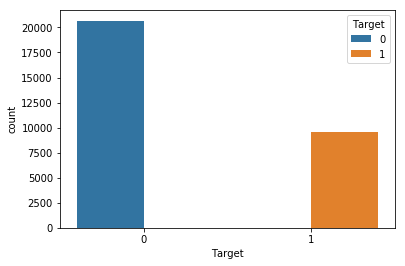

In [11]:
# Count plot, x Target, color is target

sns.countplot(x = 'Target', hue = 'Target', data = df_dropdup)

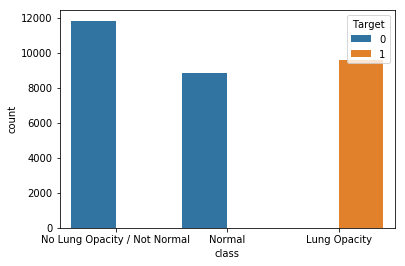

In [12]:
sns.countplot(x = 'class', hue = 'Target', data = df_dropdup)

### Are there multiple images for one patient? yes

In [13]:

print(df_dropdup['patientId'].value_counts().unique())

#Group by patientId and count
print(df_dropdup['patientId'].value_counts().value_counts())

# check the head
print(df_dropdup['patientId'].value_counts().head(5))


[4 3 2 1]
1    23286
2     3266
3      119
4       13
Name: patientId, dtype: int64
3239951b-6211-4290-b237-3d9ad17176db    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
76f71a93-8105-4c79-a010-0cfa86f0061a    4
0d5bc737-03de-4bb8-98a1-45b7180c3e0f    4
Name: patientId, dtype: int64


### 3: Merge with box counts

Yes. These are the number of bounding boxes for patients?

In [14]:
box_counts = df_dropdup.groupby(['patientId','Target'])\
.size()\
.sort_values(ascending=False)\
.reset_index(name='boxes')
box_counts.head(2)

,patientId,Target,boxes
0,7d674c82-5501-4730-92c5-d241fd6911e7,1,4
1,31764d54-ea3b-434f-bae2-8c579ed13799,1,4


In [15]:
df_box = pd.merge(df_dropdup, box_counts, on = 'patientId',how='left')
df_box.head()

df_box.to_csv('data/processed/df_train_labels_infor_boxes_merge.csv', index = False)

### 4. Summary of box count

In [16]:
box_count_sum = df_box.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')

box_count_sum.to_csv('data/processed/df_boxe_count_sum.csv', index = False)

Yes. Target =1 group can have more than 1 picture. **Why? ** 

### 4. The size of boxes 

In [17]:

df_box['x_2'] = df_box['x'] + df_box['width']
df_box['y_2'] = df_box['y'] + df_box['height']
df_box['x_center'] = df_box['x'] + df_box['width'] / 2
df_box['y_center'] = df_box['y'] + df_box['height'] / 2
df_box['area'] = df_box['width'] * df_box['height']

print(df_box.head())

                              patientId      x      y  width  height  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   

   Target_x                         class  Target_y  boxes    x_2    y_2  \
0         0  No Lung Opacity / Not Normal         0      1    NaN    NaN   
1         0  No Lung Opacity / Not Normal         0      1    NaN    NaN   
2         0  No Lung Opacity / Not Normal         0      1    NaN    NaN   
3         0                        Normal         0      1    NaN    NaN   
4         1                  Lung Opacity         1      2  477.0  531.0   

   x_center  y_center     area  
0       NaN       NaN      NaN  
1       NaN       NaN      NaN  
2       NaN

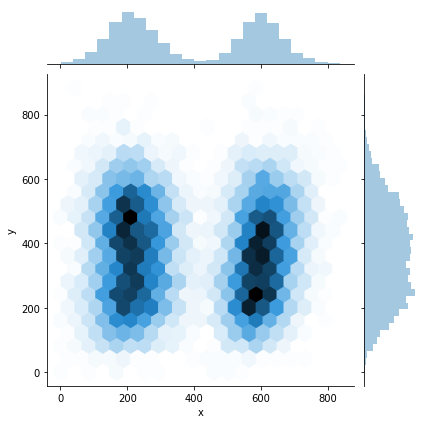

In [18]:
# What are the upper boundaries of bounding boxes?
sns.jointplot(x = 'x', y = 'y', data = df_box,kind ='hex', gridsize = 20)

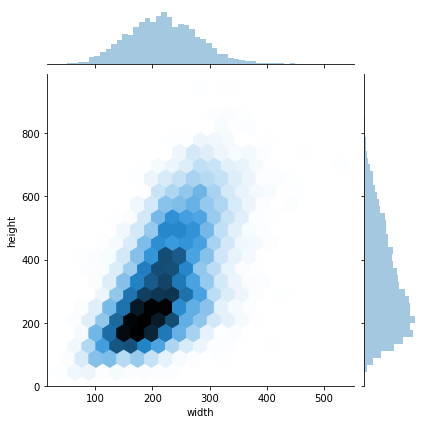

In [19]:
# How big are the bounding boxes?
sns.jointplot(x = 'width', y = 'height', data = df_box,kind ='hex', gridsize = 20)

### Drop useless features in the meta data 

### Draw a correlation map of factors 

Important factors to keep 
sex, age 

## II Image Part 

### How does a pneumonia DICOM image look like?

In [20]:
train_path = "data/raw/stage_2_train_images/"
train_dicom = [f for f in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, f))]

print(train_dicom[:1])


['7be6b4de-afe9-43c0-a581-0f49608c8976.dcm']


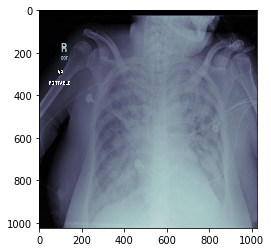

In [21]:
# check an image with 4 boxes 
# 7d674c82-5501-4730-92c5-d241fd6911e7
#doc
file = pydicom.read_file("data/raw/stage_2_train_images/7d674c82-5501-4730-92c5-d241fd6911e7.dcm")
import matplotlib.pyplot as plt

plt.imshow(file.pixel_array, cmap=plt.cm.bone) 

## Add bounding boxes 

In [22]:
df_box[df_box['patientId'].str.match('7d674c82-5501-4730-92c5-d241fd6911e7')]

,patientId,x,y,width,height,Target_x,class,Target_y,boxes,x_2,y_2,x_center,y_center,area
12251,7d674c82-5501-4730-92c5-d241fd6911e7,358.0,320.0,159.0,186.0,1,Lung Opacity,1,4,517.0,506.0,437.5,413.0,29574.0
12252,7d674c82-5501-4730-92c5-d241fd6911e7,283.0,528.0,197.0,314.0,1,Lung Opacity,1,4,480.0,842.0,381.5,685.0,61858.0
12253,7d674c82-5501-4730-92c5-d241fd6911e7,718.0,573.0,133.0,227.0,1,Lung Opacity,1,4,851.0,800.0,784.5,686.5,30191.0
12254,7d674c82-5501-4730-92c5-d241fd6911e7,658.0,315.0,164.0,203.0,1,Lung Opacity,1,4,822.0,518.0,740.0,416.5,33292.0


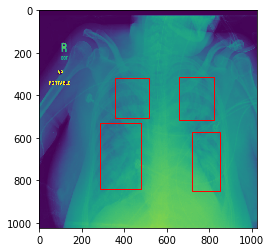

In [23]:
im = file.pixel_array
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect1 = patches.Rectangle((358,320),159,186,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((283,528),197,314,linewidth=1,edgecolor='r',facecolor='none')
rect3 = patches.Rectangle((718,573),133,277,linewidth=1,edgecolor='r',facecolor='none')
rect4 = patches.Rectangle((658,315),164,203,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
plt.show()

## Let's check a negative case 

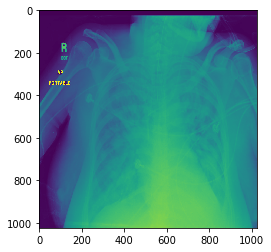

In [68]:
#doc
neg = pydicom.read_file("data/raw/stage_2_train_images/4ba3e640-eb0a-4f4f-900c-af7405bc1790.dcm")
#plt.imshow(file.pixel_array, cmap=plt.cm.bone) 
df_dropdup[df_dropdup['patientId'].str.match('4ba3e640-eb0a-4f4f-900c-af7405bc1790')]

im2 = neg.pixel_array
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
# Add the patch to the Axes

plt.show()

# Model

## Transfer learning using MASK_RCNN  

In [84]:
os.chdir('/home/ubuntu/healthcare/pneumonia_lungfish/models/')
# Import Mask RCNN
sys.path.append(os.path.join(work_DIR, 'Mask_RCNN'))  # To find local version of the library

Using TensorFlow backend.


In [85]:
train_dicom_dir = os.path.join(data_DIR, 'stage_2_train_images')
#test_dicom_dir = os.path.join(data_DIR, 'stage_2_test_images')

In [ ]:
### Download weights in the /models/weights directory
os.chdir('/home/ubuntu/healthcare/pneumonia_lungfish/models/weights')
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [88]:
!ls -lh mask_rcnn_coco.h5
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"


-rw-r--r--@ 1 j  staff   246M 26 Nov  2017 mask_rcnn_coco.h5


Some setup functions and classes for Mask-RCNN
* dicom_fps is a list of the dicom image path and filenames
* image_annotions is a dictionary of the annotations keyed by the filenames
* parsing the dataset returns a list of the image filenames and the annotations dictionary
